In [1]:
import re
import string
import spacy
import psycopg2
import pandas as pd
from math import log
import numpy as np
from typing import List, Dict
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder

import nltk
from nltk.collections import *

import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.colors as colors

/home/triplem/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/triplem/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [2]:
params = {
    "host": "localhost",
    "port": 5432,
    "database": "Medhelp",
    "user": "postgres",
    "password": "qwe123!@#",
}
conn = psycopg2.connect(**params)
cur = conn.cursor()

In [3]:
sql_fetch_data = """
    SELECT
        Q.subj_id, Q.subj_title, Q.subj_msg, Q.created_timestamp, P.post_msg, P.created_timestamp
    FROM 
        question AS Q
    JOIN 
        post AS P ON (Q.subj_id = P.subj_id)
    WHERE
        Q.answer_count >= 10
        AND P.type = 'Answer'
    ORDER BY
        Q.created_timestamp DESC
"""
cur.execute(sql_fetch_data)
raw_data = cur.fetchall()

In [4]:
def create_corpus(r_data: List[tuple]) -> List[dict]:
    ordered_subj_colnames = ["subj_id", "subj_title", "subj_msg", "subj_timestamp"]
    corpus, current_conversation = list(), None
    
    for row in r_data:
        if current_conversation and current_conversation["subj_id"] != row[0]:
            corpus.append(current_conversation)
            current_conversation = None
            
        if current_conversation is None:
            current_conversation = dict((col_name, val) for col_name, val in zip(ordered_subj_colnames, row[:-2]))
            current_conversation["answers"] = []
            
        current_conversation["answers"].append(row[-2])
    
    if current_conversation:
        corpus.append(current_conversation)
    
    return corpus

In [5]:
def sentence_segmentation(corpus: List[dict]) -> Dict[str, dict]:
    nlp = spacy.load('en_core_web_sm')
    segmented_conversations = defaultdict(dict)
    
    for conversation in corpus:
        question_doc = nlp(conversation["subj_msg"]) # default string type is Unicode
        
        answer_sentences = []
        for answer_txt in conversation["answers"]:
            answer_doc = nlp(answer_txt)
            answer_sentences.extend([ans_sent.text for ans_sent in answer_doc.sents])
            
        segmented_conversations[conversation["subj_title"]].update(
            {
                "subj_sents": [que_sent.text for que_sent in question_doc.sents],
                "ans_sents": answer_sentences
            }
        )
    
    return dict(segmented_conversations)

In [ ]:
nlp = spacy.load('en_core_web_sm')
txt = 'Has anyone experienced blood pressure of over 280 close to 300? Could you please share what you were feeling at the time, all your symptoms etc. It would be so helpful to get insight..thank you!'
doc = nlp(txt)
print(type(doc), doc[0].is_sent_start)
[token.text for token in doc]

In [6]:
sentence_segmentation(create_corpus(raw_data))

{'blood pressure above 280': {'subj_sents': ['Has anyone experienced blood pressure of over 280 close to 300?',
   'Could you please share what you were feeling at the time, all your symptoms etc.',
   'It would be so helpful to get insight..',
   'thank you!'],
  'ans_sents': ['My blood pressure was at 280 when the medics came to take me to the emergency room.\xa0\xa0',
   'I became nauseous, experienced chest pains that felt like pressure on my chest and upper arms, and felt like I needed to lie down.\xa0\xa0',
   'Although I functioned, I later remembered little of anything.\xa0\xa0',
   "I don't remember my blood pressure being taken or the ambulance ride to the doctor.\xa0\xa0",
   'My blood pressure was down to 220 before I started remembering anything.\xa0\xa0',
   "The doctors said that I didn't have a heart attack, but until the catheterization, they thought that I had because of the enzyme troponin that my heart produced.\xa0\xa0",
   'Hope this helps',
   'I am sharing to so

In [ ]:
corpus_df = pd.DataFrame(raw_data,
                         columns=["subj_id", "subj_title", "subj_msg", "subj_timestamp", "post_msg", "post_timestamp"])

most frequently used context window === sentence

In [6]:
stop_words = set(stopwords.words("english"))

def preprocess_sentence(sentence: str) -> List[str]:
    # Apply removal of URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    sentence = url_pattern.sub(r'', sentence)
    
    # Apply initial punctuations removal with Regex
    punctuation_pattern = r"[^\w\s]"
    sentence = re.sub(punctuation_pattern, '', sentence)
    
    # Punctuation removal (using string.punctuation for efficiency)
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    
    # Perform tokenization, lowercase conversion, punctuation/symbol removal
    tokens = word_tokenize(sentence.lower())
    tokens = [token for token in tokens if token not in stop_words]

    # Apply lemmatization using WordNetLemmatizer (OR stemming)
    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(token) for token in tokens]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos="v") for token in tokens]
    
    return tokens


### Preprocess corpus tokens

In [7]:
corpus = create_corpus(raw_data)
corpus_sentences = sentence_segmentation(corpus)
corpus_filtered_tokens = dict()

for title, conversation_sents in corpus_sentences.items():
    questions_tokens, answer_tokens = list(), list()
    for conv_part, sents in conversation_sents.items():
        for sent in sents:
            if type(sent) != str:
                raise TypeError(f"{sent} |  {type(sent)}")
            tokens = preprocess_sentence(sent)
            if conv_part == "subj_sents":
                questions_tokens.append(tokens)
            elif conv_part == "ans_sents":
                answer_tokens.append(tokens)
    corpus_filtered_tokens[title] = {
        "subj_tokens": questions_tokens,
        "ans_tokens": answer_tokens,
    }
corpus_filtered_tokens

{'blood pressure above 280': {'subj_tokens': [['anyone',
    'experience',
    'blood',
    'pressure',
    '280',
    'close',
    '300'],
   ['could', 'please', 'share', 'feel', 'time', 'symptoms', 'etc'],
   ['would', 'helpful', 'get', 'insight'],
   ['thank']],
  'ans_tokens': [['blood',
    'pressure',
    '280',
    'medics',
    'come',
    'take',
    'emergency',
    'room'],
   ['become',
    'nauseous',
    'experience',
    'chest',
    'pain',
    'felt',
    'like',
    'pressure',
    'chest',
    'upper',
    'arm',
    'felt',
    'like',
    'need',
    'lie'],
   ['although', 'function', 'later', 'remember', 'little', 'anything'],
   ['dont',
    'remember',
    'blood',
    'pressure',
    'take',
    'ambulance',
    'ride',
    'doctor'],
   ['blood', 'pressure', '220', 'start', 'remember', 'anything'],
   ['doctor',
    'say',
    'didnt',
    'heart',
    'attack',
    'catheterization',
    'think',
    'enzyme',
    'troponin',
    'heart',
    'produce'],
   

In [8]:
# A collection of bigram association measures
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [ ]:
BigramCollocationFinder.from_words(
    corpus_filtered_tokens["blood pressure above 280"]["subj_tokens"]).nbest(
        score_fn=bigram_measures.pmi, # Pointwise Mutual Information (PMI)
        n=100) # Select top 100 bigrams

### Calculate multi-word unit candidates

In [9]:
def extract_corpus_bigrams(corpus_filtered_tokens: Dict[str, dict],
                           min_freq: int = 2,
                           score_fn: callable = bigram_measures.pmi,
                           n: int = 10000
                           ) -> Dict[str, list]:
    corpus_bigram_collections = dict()
    
    for title, conversation_filtered_tokens in corpus_filtered_tokens.items():  
        # make a flat list out of a list of lists
        subj_tokens = [t for l in conversation_filtered_tokens["subj_tokens"] for t in l]
        ans_tokens = [t for l in conversation_filtered_tokens["ans_tokens"] for t in l]
        
        subj_finder = BigramCollocationFinder.from_words(subj_tokens)
        answer_finder = BigramCollocationFinder.from_words(ans_tokens)
        
        # Removes candidate which have frequency less than min_freq
        subj_finder.apply_freq_filter(int(min_freq))
        answer_finder.apply_freq_filter(int(min_freq))
        
        subj_bigram_collections = subj_finder.nbest(score_fn=score_fn, n=n)
        answer_bigram_collections = answer_finder.nbest(score_fn=score_fn, n=n)
        
        corpus_bigram_collections[title] = (subj_bigram_collections + answer_bigram_collections)
        
    # for bi in (subj_bigram_collections + answer_bigram_collections):
    #     print(bi[0], bi[1], end=" ")
    #     print(subj_finder.score_ngram(bigram_measures.pmi, bi[0], bi[1]))
    
    return corpus_bigram_collections
        
extract_corpus_bigrams(corpus_filtered_tokens, score_fn=bigram_measures.raw_freq)

{'blood pressure above 280': [('blood', 'pressure'),
  ('heart', 'attack'),
  ('let', 'go'),
  ('take', 'bp'),
  ('chest', 'pain'),
  ('emergency', 'room'),
  ('feel', 'anything'),
  ('go', 'back'),
  ('adrenal', 'glands'),
  ('ask', 'doctor'),
  ('black', 'chunk'),
  ('bp', 'spike'),
  ('cause', 'heart'),
  ('chance', 'survival'),
  ('couple', 'hours'),
  ('difficulty', 'breathe'),
  ('doctor', 'blood'),
  ('doctor', 'could'),
  ('don39t', 'feel'),
  ('enough', 'kill'),
  ('eventually', 'lead'),
  ('extremely', 'high'),
  ('feel', 'head'),
  ('feel', 'something'),
  ('felt', 'like'),
  ('go', 'see'),
  ('heart', 'surgery'),
  ('high', 'blood'),
  ('hope', 'help'),
  ('hospital', 'immediately'),
  ('leave', 'side'),
  ('medical', 'exam'),
  ('miss', 'mum'),
  ('mother', 'die'),
  ('mum', 'miss'),
  ('onslaught', 'adrenalin'),
  ('perform', 'wrong'),
  ('repair', 'heart'),
  ('saw', 'bp'),
  ('send', 'home'),
  ('serious', 'complications'),
  ('several', 'serious'),
  ('severe', 'headac

In [74]:
pd.Series(['a|ba|a', 'a|b', 'a|c']).str.get_dummies()

a  b  ba  c
0  1  0   1  0
1  1  1   0  0
2  1  0   0  1

In [76]:
def create_binary_dtm(corpus_filtered_tokens: Dict[str, list],
                      minimum_frequency: int = 0):
    """
    Creates a document-term matrix (DTM) and sets binary values for presence/absence of types.

    Returns:
        pd.DataFrame: The binary DTM.
    """
    corpus_dtm = dict()
    for title, conv_filtered_tokens in corpus_filtered_tokens.items():
        # Create Document-Term Matrix (DTM) using pandas.Series.str.get_dummies()
        dtm = pd.Series([",".join(sent_tokens) 
                        for sents in conv_filtered_tokens.values()
                        for sent_tokens in sents]
                        ).str.get_dummies(sep=",")

        # Prune vocabulary based on minimum document frequency
        # dtm = dtm.filter(like=".*_.{" + str(minimum_frequency) + ",}", axis=1)

        # Set binary values for presence/absence of tokens
        dtm = dtm.applymap(lambda x: 1 if x > 0 else 0)

        corpus_dtm[title] = dtm

    return corpus_dtm

create_binary_dtm(corpus_filtered_tokens)

{'blood pressure above 280':      10  100  110  13  14080i  15  180  181100  190  2  ...  would  wouldn39t  \
 0     0    0    0   0       0   0    0       0    0  0  ...      0          0   
 1     0    0    0   0       0   0    0       0    0  0  ...      0          0   
 2     0    0    0   0       0   0    0       0    0  0  ...      1          0   
 3     0    0    0   0       0   0    0       0    0  0  ...      0          0   
 4     0    0    0   0       0   0    0       0    0  0  ...      0          0   
 ..   ..  ...  ...  ..     ...  ..  ...     ...  ... ..  ...    ...        ...   
 161   0    0    0   0       0   0    0       0    0  0  ...      0          0   
 162   0    0    0   0       1   0    0       0    0  0  ...      0          0   
 163   0    0    0   0       0   0    0       0    0  0  ...      0          0   
 164   0    0    0   0       0   0    0       0    0  0  ...      0          0   
 165   0    0    0   0       0   0    0       0    0  0  ...      0   

### Counting co-occurrences

In [11]:
def calculate_cooccurrence_counts(binary_dtm):
    cooccurrence_counts = binary_dtm.T @ binary_dtm  # Matrix multiplication using @ operator
    return cooccurrence_counts

binary_corpus_dtm = create_binary_dtm(corpus_filtered_tokens)
coocs = dict()
for title, binary_dtm in binary_corpus_dtm.items():
    cooccurrence_counts = calculate_cooccurrence_counts(binary_dtm)
    coocs[title] = cooccurrence_counts

# Select the desired submatrix (rows 202-205, columns 202-205)
# submatrix = cooccurrence_counts.iloc[500:530, 500:530]
# submatrix
coocs

{'blood pressure above 280':         10  100  110  13  14080i  15  180  181100  190  2  ...  would  \
 10       1    0    0   0       0   0    0       0    1  0  ...      0   
 100      0    1    0   0       0   0    0       0    0  0  ...      0   
 110      0    0    1   0       0   0    1       0    0  0  ...      0   
 13       0    0    0   1       0   0    0       1    0  0  ...      0   
 14080i   0    0    0   0       1   0    0       0    0  0  ...      0   
 ...     ..  ...  ...  ..     ...  ..  ...     ...  ... ..  ...    ...   
 yes      0    0    0   0       0   0    0       0    0  0  ...      0   
 youre    0    0    0   0       0   0    0       0    0  0  ...      0   
 youve    0    0    0   0       0   0    0       0    0  0  ...      1   
 yrs      0    0    0   0       0   0    0       0    0  0  ...      0   
 zone     0    0    0   0       0   0    0       0    0  0  ...      0   
 
         wouldn39t  wrong  year  years  yes  youre  youve  yrs  zone  
 10        

### Statistical significance

In [12]:
def calculate_cooccurrence_scores(cooccurrence_counts: pd.DataFrame,
                                              word_of_interest: str,
                                              normalize: bool = True,
                                              top_n: int = 20,
                                              measure = "LOGLIK",
                                              ) -> pd.DataFrame:
    """
    Calculates various co-occurrence scores for a given word and returns a DataFrame.
    
    Returns:
        pd.DataFrame: A DataFrame containing calculated scores and top co-occurring words.
    """

    try:
        # Ensure word_of_interest exists in the co-occurrence matrix
        cooccurrence_counts.loc[word_of_interest]
    except KeyError:
        print(
            f"Word '{word_of_interest}' not found in the co-occurrence matrix.")
        return pd.Series()

    # Number of all context units in the corpus
    k = cooccurrence_counts.shape[0]
    # print(k)
    # print('------------')
    nij = cooccurrence_counts.loc[word_of_interest, :]
    # print(nij)
    # print('------------')
    # Number of occurrences of the word_of_interest
    ki = nij.sum()
    # print("ki", ki)
    # print('------------')
    # Number of occurrences of comparison term j
    kj = cooccurrence_counts.sum(axis=0)
    # print(kj)
    # print('------------')

    # Handle invalid measure choices
    if measure not in ("MI", "DICE", "LOGLIK"):
        raise ValueError(f"Invalid measure: {measure}. Supported measures are 'MI', 'DICE', and 'LOGLIK'.")


    # MI: log(k*kij / (ki * kj) ######## Calculate scores
    if normalize:
        # Mutual Information (normalized)
        mutual_information_sig = np.log(k * nij / (ki * kj)) if ki else 0
    else:
        # Mutual Information (raw)
        mutual_information_sig = np.log(k * nij)

    # DICE: 2 X&Y / X + Y ############## Dice coefficient
    dice_sig = 2 * nij / (ki + kj) if ki else 0

    ########## Log Likelihood ##########
    log_likelihood_sig = 2 * (  
        (k * log(k))
        - (ki * log(ki))
        - (kj * np.log(kj))
        + (nij * np.log(nij))
        + ((k - ki - kj + nij) * np.log(k - ki - kj + nij))
        + ((ki - nij) * np.log(ki - nij))
        + ((kj - nij) * np.log(kj - nij))
        - ((k - ki) * log(k - ki) if k - ki > 0 else 0)
        - ((k - kj) * np.log(k - kj))
    )

    # Sort and select top terms based on frequency
    top_terms = nij.sort_values(ascending=False).index[:top_n]

    # Create DataFrame with results
    result_df = pd.DataFrame({
        "Freq-terms": top_terms,
        "Freq": nij[top_terms],
        "MI-terms": top_terms,
        "MI": mutual_information_sig[top_terms],
        "Dice-Terms": top_terms,
        "Dice": dice_sig[top_terms],
        "LL-Terms": top_terms,
        "LL": log_likelihood_sig[top_terms],
    })
    
    # print(result_df)

    if measure == "MI":
        result_df.drop(["Freq", "MI-terms", "Dice-Terms", "Dice", "LL-Terms", "LL"], axis=1, inplace=True)
        result_df.rename(columns={"MI": "score"}, inplace=True)
    elif measure == "DICE":
        result_df.drop(["Freq", "Dice-Terms", "MI-terms", "MI", "LL-Terms", "LL"], axis=1, inplace=True)
        result_df.rename(columns={"Dice": "score"}, inplace=True)
    elif measure == "LOGLIK":
        result_df.drop(["Freq", "LL-Terms", "MI-terms", "MI", "Dice-Terms", "Dice"], axis=1, inplace=True)
        result_df.rename(columns={"LL": "score"}, inplace=True)

    return result_df

word_of_interest = "pressure"
result_df = dict()
for title, cooccurrence_counts in coocs.items():
    result_df[title] = calculate_cooccurrence_scores(
        cooccurrence_counts, word_of_interest)
result_df

/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarni

{'blood pressure above 280':               Freq-terms       score
 pressure        pressure  105.074840
 blood              blood  247.731708
 take                take  128.181371
 280                  280   39.469054
 300                  300   29.524604
 experience    experience   34.807321
 start              start   31.758474
 close              close   25.715988
 doctor            doctor   88.810704
 cause              cause  177.087412
 high                high   78.479227
 chest              chest   48.597949
 heart              heart  327.569635
 remember        remember    5.719597
 immediately  immediately   45.974039
 get                  get  128.437630
 tell                tell   69.495154
 repair            repair   57.942087
 find                find   47.653135
 pain                pain   31.348144,
 'Is Beetroot Capsule a high blood pressure drug ?':                       Freq-terms       score
 blood                      blood   80.882472
 pressure                pres

In [47]:
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Visualization of co-occurrence

In [13]:
def build_cooccurrence_network(cooccurrence_counts: pd.DataFrame,
                                word_of_interest: str,
                                normalize: bool = True,
                                top_n: int = 300,
                                measure: str = "DICE",
                                depth: int = 2
                                ):
    """
    Builds a co-occurrence network centered around a given word and measures co-occurrence at specified depth.

    Returns:
        pd.DataFrame: A DataFrame containing the built network as:
            - columns: "From", "To", "Score", "Level"
            - rows: One row per network edge
    """

    # Handle invalid measure choices
    if measure not in ("MI", "DICE", "LOGLIK"):
        raise ValueError(f"Invalid measure: {measure}. Supported measures are 'MI', 'DICE', and 'LOGLIK'.")

    # Initialize result DataFrame for edges
    result_df = pd.DataFrame(columns=["From", "To", "Score", "Level"])

    # Start by exploring co-occurrences of the word_of_interest
    current_level = 1
    visited_words = set([word_of_interest])  # Track visited words to avoid cycles
    coocs = calculate_cooccurrence_scores(cooccurrence_counts, word_of_interest,
                                          top_n=top_n, measure=measure, normalize=normalize)

    while current_level <= depth and not coocs.empty:
        # Add edges for current level co-occurrences
        for new_term, score in coocs.itertuples(index=False):
            if new_term not in visited_words and score:
                pd.concat([result_df, pd.DataFrame.from_records([{
                    "From": word_of_interest,
                    "To": new_term,
                    "Score": score,
                    "Level": current_level,
                }])])
                visited_words.add(new_term)

        # Explore co-occurrences of top terms at this level
        if current_level < depth:
            next_level_terms = []
            for new_term, _ in coocs.itertuples(index=False):
                # Avoid re-exploring already visited terms
                if new_term not in visited_words:
                    next_level_terms.append(new_term)
            if next_level_terms:
                next_level_df = cooccurrence_counts[next_level_terms].T.apply(
                    lambda series: build_cooccurrence_network(cooccurrence_counts, 
                                                              series.name,
                                                              top_n=top_n, 
                                                              measure=measure, 
                                                              normalize=normalize,
                                                              depth=depth-current_level),
                    axis=1
                )
                # print(next_level_df)
                # Aggregate results from child networks and adjust levels
                if not next_level_df.empty:
                    print(next_level_df.empty)
                    print(next_level_df)
                    next_level_df.columns = ["From", "To", "Score", "Level"]
                    
                    next_level_df["Level"] += current_level
                    result_df = pd.concat([result_df, next_level_df])

        current_level += 1
        coocs = pd.DataFrame()  # Reset co-occurrences for next level

    return result_df

In [15]:
import pandas as pd

def _build_cooccurrence_network(cooccurrence_counts: pd.DataFrame,
                                word_of_interest: str,
                                normalize: bool = True,
                                top_n: int = 300,
                                measure: str = "DICE",
                                depth: int = 2
                                ):
    """
    Builds a co-occurrence network centered around a given word and measures co-occurrence at specified depth.

    Returns:
        pd.DataFrame: A DataFrame containing the built network as:
            - columns: "From", "To", "Score", "Level"
            - rows: One row per network edge
    """

    # Handle invalid measure choices
    if measure not in ("MI", "DICE", "LOGLIK"):
        raise ValueError(f"Invalid measure: {measure}. Supported measures are 'MI', 'DICE', and 'LOGLIK'.")

    def _build_network_recursive(current_word, current_level, remaining_depth):
        """Recursive helper function to build the network."""
        results = []
        coocs = calculate_cooccurrence_scores(cooccurrence_counts, current_word,
                                              top_n=top_n, measure=measure, normalize=normalize)
        for new_term, score in coocs.itertuples(index=False):
            if score:  # Ensure scores are not zero
                results.append({
                    "From": current_word,
                    "To": new_term,
                    "Score": score,
                    "Level": current_level,
                })
            if remaining_depth > 1:
                results.extend(_build_network_recursive(new_term, current_level + 1, remaining_depth - 1))
        return results

    # Build the network using recursion
    result_df = pd.DataFrame(_build_network_recursive(word_of_interest, 1, depth))

    return result_df


In [16]:
word_of_interest = "pressure"
result_cooccurrence_df = dict()
for title, cooccurrence_counts in coocs.items():
    # result_cooccurrence_df[title] = build_cooccurrence_network(
    #     cooccurrence_counts, word_of_interest)
    result_cooccurrence_df[title] = _build_cooccurrence_network(
        cooccurrence_counts, word_of_interest)
print(result_cooccurrence_df)

/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarn

{'blood pressure above 280':           From        To     Score  Level
0     pressure  pressure  0.077273      1
1     pressure  pressure  0.077273      2
2     pressure     blood  0.055249      2
3     pressure      take  0.024938      2
4     pressure       280  0.026756      2
...        ...       ...       ...    ...
9434    waiver      feel  0.021277      2
9435    waiver     could  0.016260      2
9436      walk      walk  0.333333      2
9437      walk      days  0.074074      2
9438      walk      like  0.062500      2

[9439 rows x 4 columns], 'Is Beetroot Capsule a high blood pressure drug ?':           From        To     Score  Level
0     pressure     blood  0.077922      1
1        blood     blood  0.084034      2
2        blood  pressure  0.077922      2
3        blood     lower  0.037559      2
4        blood      high  0.042105      2
...        ...       ...       ...    ...
5253      good      high  0.022727      2
5254      good    garlic  0.017094      2
5255      g

/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/triplem/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [89]:
def build_and_plot_cooccurrence_network(result_df,
                                        word_of_interest, 
                                        depth=1,
                                        layout="fruchterman_reingold"
                                        ) -> None:
    """
    Builds a co-occurrence network based on a DataFrame and plots it using Matplotlib.
    """

    # Create an empty networkx graph
    G = nx.Graph()

    # Add nodes and edges from the DataFrame
    for _, row in result_df.iterrows():
        from_node = row["From"]
        to_node = row["To"]
        score = row["Score"]
        level = row["Level"]

        # Add nodes if not already present
        if from_node not in G.nodes:
            G.add_node(from_node, level=level)
        if to_node not in G.nodes:
            G.add_node(to_node, level=level)

        # Add edge with attributes
        G.add_edge(from_node, to_node, weight=score, level=level)

    # # Identify nodes with degree < 2 and remove them
    # nodes_to_remove = [node for node, degree in G.degree() if degree < 2]
    # G.remove_nodes_from(nodes_to_remove)

    # Define node and edge colors and sizes based on attributes
    node_color = ["red" if node == word_of_interest else "cornflowerblue" for node in G.nodes]
    edge_color = "grey"  # Adjust if desired
    edge_width = np.array([
        value * 0.5 + 0.5  # Rescale between 0.5 and 1 for transparency
        for value in nx.get_edge_attributes(G, "weight").values()
    ])
    # node_size = np.array([
    #     (np.log(degree) - np.min(list(nx.degree(G).values()))) /
    #     (np.max(list(nx.degree(G).values())) - np.min(list(nx.degree(G).values()))) * 10 + 5
    #     for degree in list(nx.degree(G).values())
    # ])
    
    node_size = np.array([
        (level - np.min(list(nx.get_node_attributes(G, "level").values()))) /
        (np.max(list(nx.get_node_attributes(G, "level").values()))) * 10 + 5
        for level in nx.get_node_attributes(G, "level").values()
    ])

    # Create Matplotlib plot and customize with desired options
    plt.figure(figsize=(10, 8))
    # pos = nx.spring_layout(G)  # Replace with layout of choice (e.g., nx.fruchterman_reingold)
    pos = nx.fruchterman_reingold_layout(G, k=0.1, iterations=2)
    
    # Exclude self-edges from the drawing
    edges_to_draw = [(u, v) for u, v in G.edges if u != v]

    nx.draw(G, 
            pos,
            node_color=node_color,
            edgelist=edges_to_draw,
            edge_color=edge_color,
            width=edge_width,
            node_size=node_size,
            with_labels=True,
            labels={node: node for node in G.nodes},
            font_weight="bold",
            alpha=0.9,
            font_size=6
            )  
    
    plt.title(f"{word_of_interest} Network")
    plt.axis("off")
    plt.show()

In [77]:
result_cooccurrence_df["blood pressure above 280"]
type(result_cooccurrence_df["blood pressure above 280"])
result_f1 = result_cooccurrence_df["blood pressure above 280"].set_index("From")["Score"].nlargest(10).reset_index()
from copy import copy
first_df = copy(result_cooccurrence_df["Is Beetroot Capsule a high blood pressure drug ?"])
result_f2 = first_df[first_df.groupby('From')['Score'].rank(method='first') <= 1]
result_f2

From      To     Score  Level
81       blood    work  0.011976      2
165   pressure    work  0.012500      2
186       high    take  0.011561      2
250      lower    high  0.012121      2
330       take    high  0.011561      2
...        ...     ...       ...    ...
5210  genetics  weight  0.032787      2
5234       get    week  0.021739      2
5237        go     try  0.037736      2
5241       god   bless  0.500000      2
5248      good   blood  0.014706      2

[300 rows x 4 columns]

In [90]:
word_of_interest = "pressure"

# Get the top 10 highest values for each group

build_and_plot_cooccurrence_network(result_f2, word_of_interest)

In [85]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def _build_and_plot_cooccurrence_network(result_df,
                                        word_of_interest, 
                                        depth=1,
                                        layout="fruchterman_reingold"
                                        ) -> None:
    """
    Builds a co-occurrence network from a DataFrame and visualizes it using Matplotlib.
    """

    # Create the networkx graph directly from the DataFrame
    G = nx.from_pandas_edgelist(result_df, source="From", target="To", edge_attr=True)

    # Assign node levels for visualization
    print(G.nodes(data=True))
    node_levels = {node: data["Level"] for node, data in G.nodes(data=True)}
    nx.set_node_attributes(G, node_levels, "Level")

    # Define visualization parameters
    node_color = ["cornflowerblue" if node == word_of_interest else "orange" for node in G.nodes]
    edge_color = "grey"  # Adjust as needed
    edge_width = [value * 0.5 + 0.5 for value in nx.get_edge_attributes(G, "weight").values()]
    node_size = [
        (level - np.min(node_levels.values())) / (np.max(node_levels.values()) - np.min(node_levels.values())) * 10 + 5
        for level in node_levels.values()
    ]

    # Create the plot with customizations
    plt.figure(figsize=(10, 8))
    if layout == "spring_layout":
        pos = nx.spring_layout(G)
    else:
        pos = nx.fruchterman_reingold_layout(G)  # Default to Fruchterman-Reingold
    nx.draw(G, pos,
           node_color=node_color,
           edge_color=edge_color,
           width=edge_width,
           node_size=node_size,
           with_labels=True,
           labels={node: node for node in G.nodes},
           font_weight="bold",
           alpha=0.7,
           font_size=12)

    plt.title(f"{word_of_interest} Network")
    plt.axis("off")
    plt.show()


In [100]:
import matplotlib.pyplot as plt
import networkx as nx


def __build_and_plot_cooccurrence_network(
    result_df, word_of_interest, depth=1, layout="fruchterman_reingold"
) -> None:
    """
    Builds and plots a co-occurrence network based on a DataFrame.

    Args:
        result_df (pd.DataFrame): DataFrame containing co-occurrence data.
        word_of_interest (str): Word to use as the central node.
        depth (int, optional): Depth of the network. Defaults to 1.
        layout (str, optional): Layout algorithm for the network. Defaults to "fruchterman_reingold".
    """

    G = nx.Graph()

    # Add nodes and edges with attributes
    for _, row in result_df.iterrows():
        source, target, score, level = row[["From", "To", "Score", "Level"]]

        G.add_node(source, level=level)
        G.add_node(target, level=level)
        G.add_edge(source, target, weight=score, level=level)

    # Filter nodes based on depth
    if depth > 1:
        filtered_nodes = [
            node
            for node, node_data in G.nodes(data=True)
            if node_data["level"] <= depth
        ]
        G = G.subgraph(filtered_nodes)

    # Define node/edge colors and sizes
    node_color = ["cornflowerblue" if node == word_of_interest else "orange" for node in G]
    edge_color = "grey"
    edge_width = np.array([0.5 + value / 2 for value in G.edges(data=True)["weight"].values()])
    node_size = np.array(
        [
            (level - min(G.nodes(data=True))["level"])
            / (max(G.nodes(data=True))["level"] - min(G.nodes(data=True))["level"])
            * 10
            + 5
            for level in G.nodes(data=True)["level"]
        ]
    )

    # Create plot and customize
    plt.figure(figsize=(10, 8))
    pos = nx.fruchterman_reingold_layout(G)
    nx.draw(
        G,
        pos,
        node_color=node_color,
        edge_color=edge_color,
        width=edge_width,
        node_size=node_size,
        with_labels=True,
        labels={node: node for node in G},
        font_weight="bold",
        alpha=0.7,
        font_size=12,
    )

    plt.title(f"{word_of_interest} Network")
    plt.axis("off")
    plt.show()



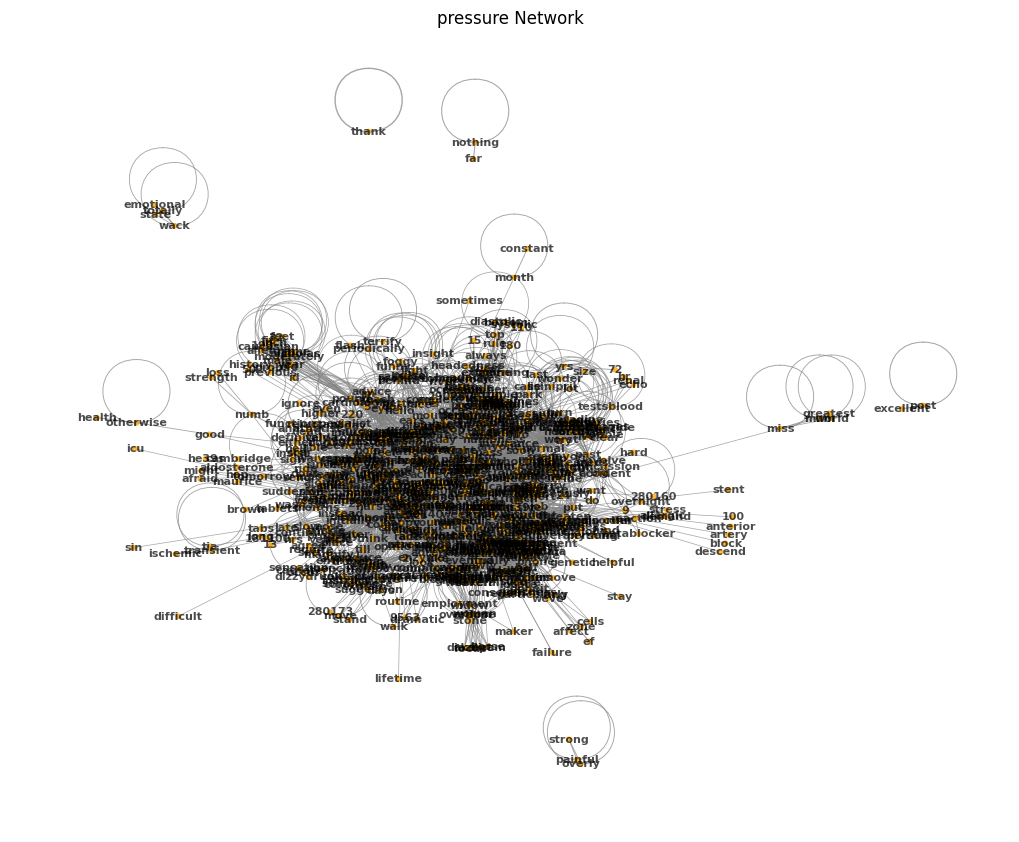

In [18]:
word_of_interest = "pressure"
build_and_plot_cooccurrence_network(result_cooccurrence_df["blood pressure above 280"], word_of_interest)